In [2]:
import matplotlib.pyplot as plt
import mudata
import numpy as np
import pandas as pd
import scanpy as sc
import snapatac2 as snap
from tqdm import tqdm
%matplotlib inline

In [3]:
luas_dir = '/data1/chanj3/LUAS.multiome.results'
adata = sc.read_h5ad(f'{luas_dir}/LUAS_tumor_rna_v4.h5ad')
vc = adata.obs['sample_name'].value_counts()
samples = list(vc.index[vc > 30])
adata = adata[adata.obs['sample_name'].isin(samples)]
print(samples)

['LUAS_32', 'LUAS_08', 'LUAS_16', 'LUAS_22', 'LUAS_03', 'LUAS_34', 'LUAS_13', 'LUAS_18', 'LUAS_15', 'LUAS_19', 'LUAS_31', 'LUAS_28', 'LUAS_14', 'LUAS_29', 'LUAS_04', 'LUAS_06']


In [4]:
seacells_dir = f'{luas_dir}/epigenetic/rna_atac_pseudotime/data/SEACells'
sample_to_seacells = {}
for sample in samples:
    sample_to_seacells[sample] = pd.read_csv(f'{seacells_dir}/{sample}_assignments.csv', index_col=0)

In [ ]:
import scipy.sparse as sp
def _pseudobulk_by_group(
    X,
    groups: pd.Categorical,
    agg="sum",
) -> sc.AnnData:
    """
    Aggregate an AnnData to metacells using a sparse indicator matrix.
    groups: categorical with length n_cells; categories are metacell ids.
    """
    # counts matrix (cells x features)
    if isinstance(X, sc.AnnData):
        var = pd.DataFrame(index=X.var_names)
        X = X.X
    else:
        var = pd.DataFrame(index=np.arange(X.shape[1]))
    n_cells = X.shape[0]
    cats = groups.categories
    codes = groups.codes

    n_groups = len(cats)
    # Build (groups x cells) indicator; 1 where cell belongs to group
    G = sp.csr_matrix(
        (np.ones(n_cells, dtype=np.float32), (codes, np.arange(n_cells))),
        shape=(n_groups, n_cells),
    )
    # Aggregate: (groups x cells) @ (cells x features) = (groups x features)
    X_sum = G @ X

    if agg == "mean":
        counts_per_group = np.asarray(G.sum(axis=1)).ravel()
        counts_per_group[counts_per_group == 0] = 1.0
        # scale rows by 1/n
        inv = sp.diags(1.0 / counts_per_group)
        X_agg = inv @ X_sum
    elif agg == "sum":
        X_agg = X_sum
    else:
        raise ValueError("agg must be 'sum' or 'mean'")

    # Build AnnData (metacells x features)
    obs = pd.DataFrame(index=cats.astype(str))
    obs["n_cells"] = np.asarray(G.sum(axis=1)).ravel().astype(int)
    pb = sc.AnnData(X_agg, obs=obs, var=var)
    # Stash some provenance
    pb.uns = {
        "aggregation": agg,
        "n_source_cells": n_cells,
    }
    return pb


peak_file = '/data1/chanj3/LUAS.multiome.results/epigenetic/gorces_2018_cancer_ATAC_data/TCGA-ATAC_PanCancer_PeakSet.bed'
sample_to_sc_mdata = {}
for sample in tqdm(samples):
    mdata = mudata.read(f'{seacells_dir}/{sample}.h5mu')
    rna = mdata['rna']
    rna.X = rna.layers['counts']
    data = snap.read(f'{luas_dir}/nf_outs/atac/atac_joint_embedding/{sample}/{sample}_snapatac2.h5ad',
                     backed=None)
    data = data[mdata.obs_names]
    peak_mat = snap.pp.make_peak_matrix(data, peak_file=peak_file)
    seacells_assns = pd.Categorical(sample_to_seacells[sample]['SEACell'])

    # Pseudobulk RNA & ATAC by SEACell (sum of counts)
    rna_pb = _pseudobulk_by_group(rna, seacells_assns, agg="sum")
    atac_pb = _pseudobulk_by_group(peak_mat, seacells_assns, agg="sum")
    joint_emb_pb = _pseudobulk_by_group(mdata.obsm['joint_embedding'], seacells_assns, agg='mean')
    
    # 6) Add convenient QC/metadata
    # totals per metacell
    rna_pb.obs["total_counts"] = np.asarray(rna_pb.X.sum(axis=1)).ravel()
    atac_pb.obs["total_counts"] = np.asarray(atac_pb.X.sum(axis=1)).ravel()
    # feature counts
    rna_pb.var["n_metacells_expressed"] = np.asarray((rna_pb.X > 0).sum(axis=0)).ravel()
    atac_pb.var["n_metacells_accessible"] = np.asarray((atac_pb.X > 0).sum(axis=0)).ravel()
    # Keep feature ids tidy
    rna_pb.var_names.name = "gene_id" if rna_pb.var_names.name is None else rna_pb.var_names.name
    atac_pb.var_names.name = "peak"

    mc = mudata.MuData({"rna": rna_pb, "atac": atac_pb})
    mc.obsm['joint_embedding'] = joint_emb_pb.X
    mc.uns["cell_to_seacell"] = pd.DataFrame(
        {"cell": rna.obs_names, "seacell": seacells_assns},
        index=rna.obs_names,
    )
    sample_to_sc_mdata[sample] = mc

  0%|          | 0/16 [00:00<?, ?it/s]/home/yangf4/envs/SnapATAC2/lib/python3.10/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/home/yangf4/envs/SnapATAC2/lib/python3.10/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)
/home/yangf4/envs/SnapATAC2/lib/python3.10/site-packages/anndata/_core/aligned_df.py

In [ ]:
concat_mdata = mudata.concat(sample_to_sc_mdata, index_unique='---', label='sample_name')

/home/yangf4/envs/SnapATAC2/lib/python3.10/site-packages/mudata/_core/merge.py:190: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  concat_indices = concat_indices.str.cat(label_col.map(str), sep=index_unique)
/home/yangf4/envs/SnapATAC2/lib/python3.10/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/home/yangf4/envs/SnapATAC2/lib/python3.10/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from indiv

In [ ]:
combined_pb_umap = []
combined_pb_umap_index = []
for sample, assns in sample_to_seacells.items():
    sample_adata = adata[adata.obs['sample_name'] == sample].copy()
    sample_adata.obs_names = sample_adata.obs_names.str.split('_').str[2]
    sample_adata = sample_adata[assns.index]
    sample_umap = sample_adata.obsm['X_umap']
    pb_umap = _pseudobulk_by_group(
        sample_umap,
        groups=pd.Categorical(assns.iloc[:, 0]),
        agg="mean",
    )
    combined_pb_umap.append(pb_umap.X)
    combined_pb_umap_index.append(pb_umap.obs_names.astype(str) + '---' + sample)

/home/yangf4/envs/SnapATAC2/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/yangf4/envs/SnapATAC2/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/yangf4/envs/SnapATAC2/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/yangf4/envs/SnapATAC2/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/yangf4/envs/SnapATAC2/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Tr

In [ ]:
combined_pb_umap = np.concatenate(combined_pb_umap)
combined_pb_umap_index = np.concatenate(combined_pb_umap_index)

In [ ]:
combined_pb_umap_df = pd.DataFrame(combined_pb_umap, index=combined_pb_umap_index)
concat_mdata.obsm['X_umap'] = combined_pb_umap_df.loc[concat_mdata.obs_names].values

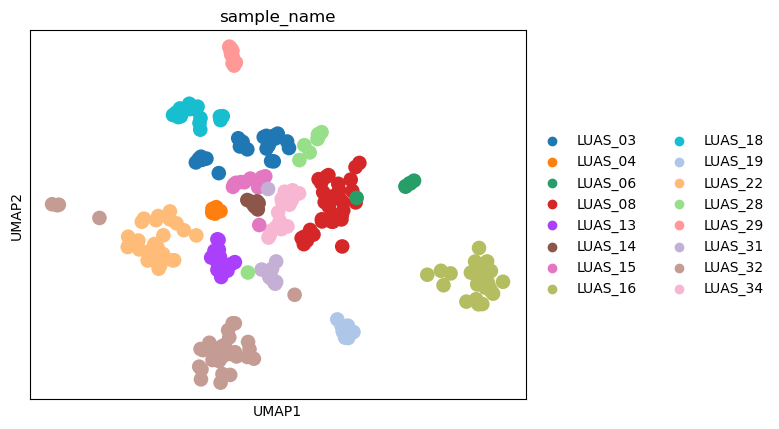

In [ ]:
concat_mdata.obs['sample_name'] = pd.Categorical(concat_mdata.obs['sample_name'].astype(str))
sc.pl.umap(concat_mdata, color=['sample_name'])

In [ ]:
del concat_mdata.uns['sample_name_colors']

In [ ]:
# concat_mdata.write(f'{seacells_dir}/combined_tumor_metacells.h5mu')

In [ ]:
concat_rna = concat_mdata['rna']
concat_atac = concat_mdata['atac']

In [ ]:
concat_rna

AnnData object with n_obs × n_vars = 272 × 34515
    obs: 'n_cells', 'total_counts', 'sample_name'

In [ ]:
concat_atac

AnnData object with n_obs × n_vars = 272 × 562709
    obs: 'n_cells', 'total_counts', 'sample_name'

In [ ]:
concat_rna.X

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 3220050 stored elements and shape (272, 34515)>

In [ ]:
concat_rna.X

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 3220050 stored elements and shape (272, 34515)>

In [ ]:
def sparsity(X):
    n, d = X.shape
    return X.count_nonzero() / (n*d)
sparsity(concat_rna.X), sparsity(concat_atac.X)

(0.34299345553084337, 0.15121978077060622)

In [ ]:
# np.save(f'{seacells_dir}/combined_tumor_metacells_rna_counts.npy', concat_rna.X.toarray())
# np.save(f'{seacells_dir}/combined_tumor_metacells_atac_counts.npy', concat_atac.X.toarray())

In [ ]:
def write_list(lst, fname):
    with open(fname, 'w') as f:
        for x in lst:
            f.write(str(x) + '\n')
# write_list(concat_atac.var_names, f'{seacells_dir}/combined_tumor_metacells_atac_peaks.txt')
# write_list(concat_rna.var_names, f'{seacells_dir}/combined_tumor_metacells_rna_genes.txt')
# write_list(concat_atac.obs_names, f'{seacells_dir}/combined_tumor_metacells_labels.txt')

In [ ]:
import pyreadr
import pickle

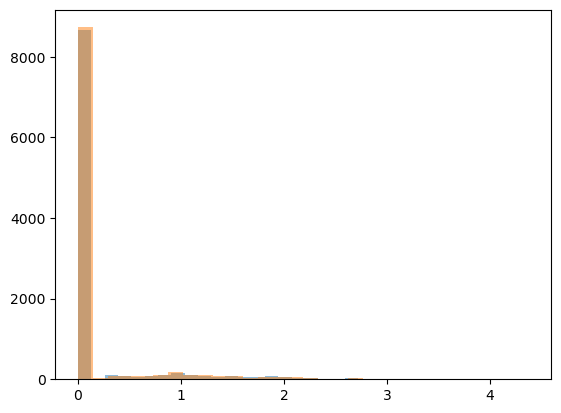

In [ ]:
def subset_peaks(exp_df, peaks):
    return exp_df.reindex(columns=peaks, fill_value=0)
peak_set = 'hvp_50000'
C = 0.001
out_dir = '/data1/chanj3/LUAS.multiome.results/epigenetic/TCGA_modeling/out'
model_dir = f'/data1/chanj3/LUAS.multiome.results/epigenetic/TCGA_modeling/out/log_reg/luad_vs_lusc_{peak_set}'
with open(f'{model_dir}/models.pkl', 'rb') as f:
    models = pickle.load(f)
atac_model = models[C]
peaks = atac_model.feature_names_in_
#X = pyreadr.read_r(f'{out_dir}/luas_cluster_log2cpm_jointTMMwsp.rds')[None].T
X = pyreadr.read_r(f'{out_dir}/metacells_atac_log2cpm_scran.rds')[None].T
X = subset_peaks(X, peaks)
plt.hist(np.random.choice(X.values.flatten(), 10000, replace=False), 30, alpha=0.5)
X[X < 0.1] = 0
plt.hist(np.random.choice(X.values.flatten(), 10000, replace=False), 30, alpha=0.5)
plt.show()
atac_probs = atac_model.predict_proba(X)

In [ ]:
sn2color = pd.read_csv('/data1/chanj3/LUAS.multiome.results/rna_clean_v4/sample2color.csv',
                       index_col=0)
sn2color.index = sn2color.index.str.split('_').str[1]
sn2color = sn2color.iloc[:, 0].to_dict()

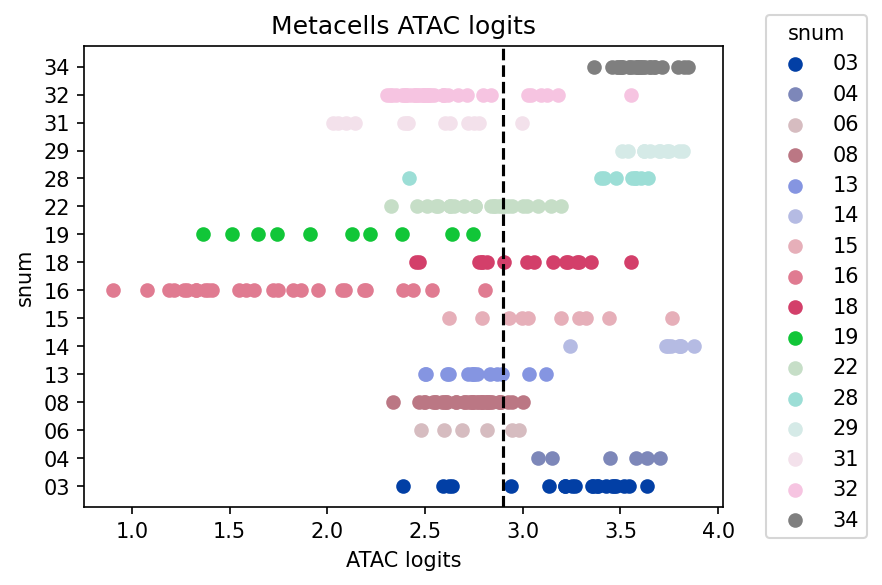

In [74]:
snums = X.index.str.split('---').str[1].str.split('_').str[1]
#snums = X.index.str.split('_').str[0]
# Assign y levels to snums
unique_snums = sorted(set(snums))
snum_to_y = {snum: i for i, snum in enumerate(unique_snums)}

# Build colors
colors = [sn2color[snum] for snum in snums]

# Compute logits
atac_logits = atac_model.decision_function(X)

# Scatter plot
plt.figure(figsize=(6, 4), dpi=150)
for snum in unique_snums:
    mask = snums == snum
    plt.scatter(
        atac_logits[mask],
        [snum_to_y[snum]] * mask.sum(),
        color=sn2color[snum],
        label=snum
    )
new_logit_baseline = 2.9
plt.axvline(new_logit_baseline, color='black', linestyle='--')
plt.yticks(range(len(unique_snums)), unique_snums)
plt.xlabel("ATAC logits")
plt.ylabel("snum")
plt.legend(title="snum", bbox_to_anchor=(1.05, 0.5), loc="center left")
plt.tight_layout()
#plt.title('Pseudobulked clusters ATAC logits')
plt.title('Metacells ATAC logits')
plt.show()

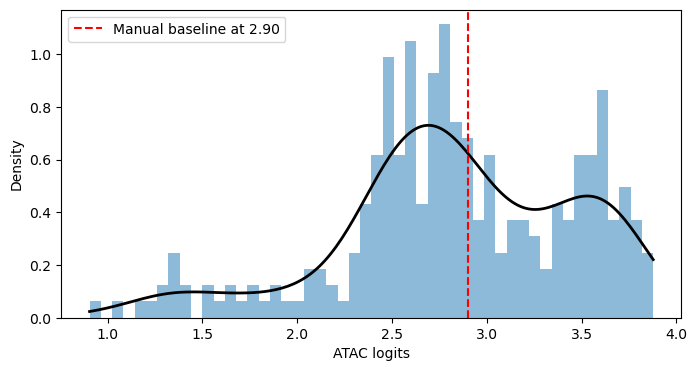

In [70]:
from scipy import stats
from scipy.signal import find_peaks

# Create density estimate
density = stats.gaussian_kde(atac_logits)
x_range = np.linspace(atac_logits.min(), atac_logits.max(), 200)
density_vals = density(x_range)

# Find local minima in density
peaks, _ = find_peaks(-density_vals)  # negative to find valleys instead of peaks
if len(peaks) > 0:
    # Get the most prominent valley
    valley_x = x_range[peaks[np.argmax(density_vals[peaks])]]
else:
    # If no clear valley, use median
    valley_x = np.median(atac_logits)
valley_x = 2.9
# Plot
plt.figure(figsize=(8, 4))
plt.hist(atac_logits, bins=50, density=True, alpha=0.5)
plt.plot(x_range, density_vals, 'k-', lw=2)
#plt.axvline(valley_x, color='r', linestyle='--', label=f'Valley at {valley_x:.2f}')
plt.axvline(valley_x, color='r', linestyle='--', label=f'Manual baseline at {valley_x:.2f}')
plt.xlabel('ATAC logits')
plt.ylabel('Density')
plt.legend()
plt.show()

/home/yangf4/envs/SnapATAC2/lib/python3.10/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/home/yangf4/envs/SnapATAC2/lib/python3.10/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)
... storing 'leiden' as categorical
/home/yangf4/envs/SnapATAC2/lib/python3.10/site-packages/mudata/_core/mudata.py:1531: 

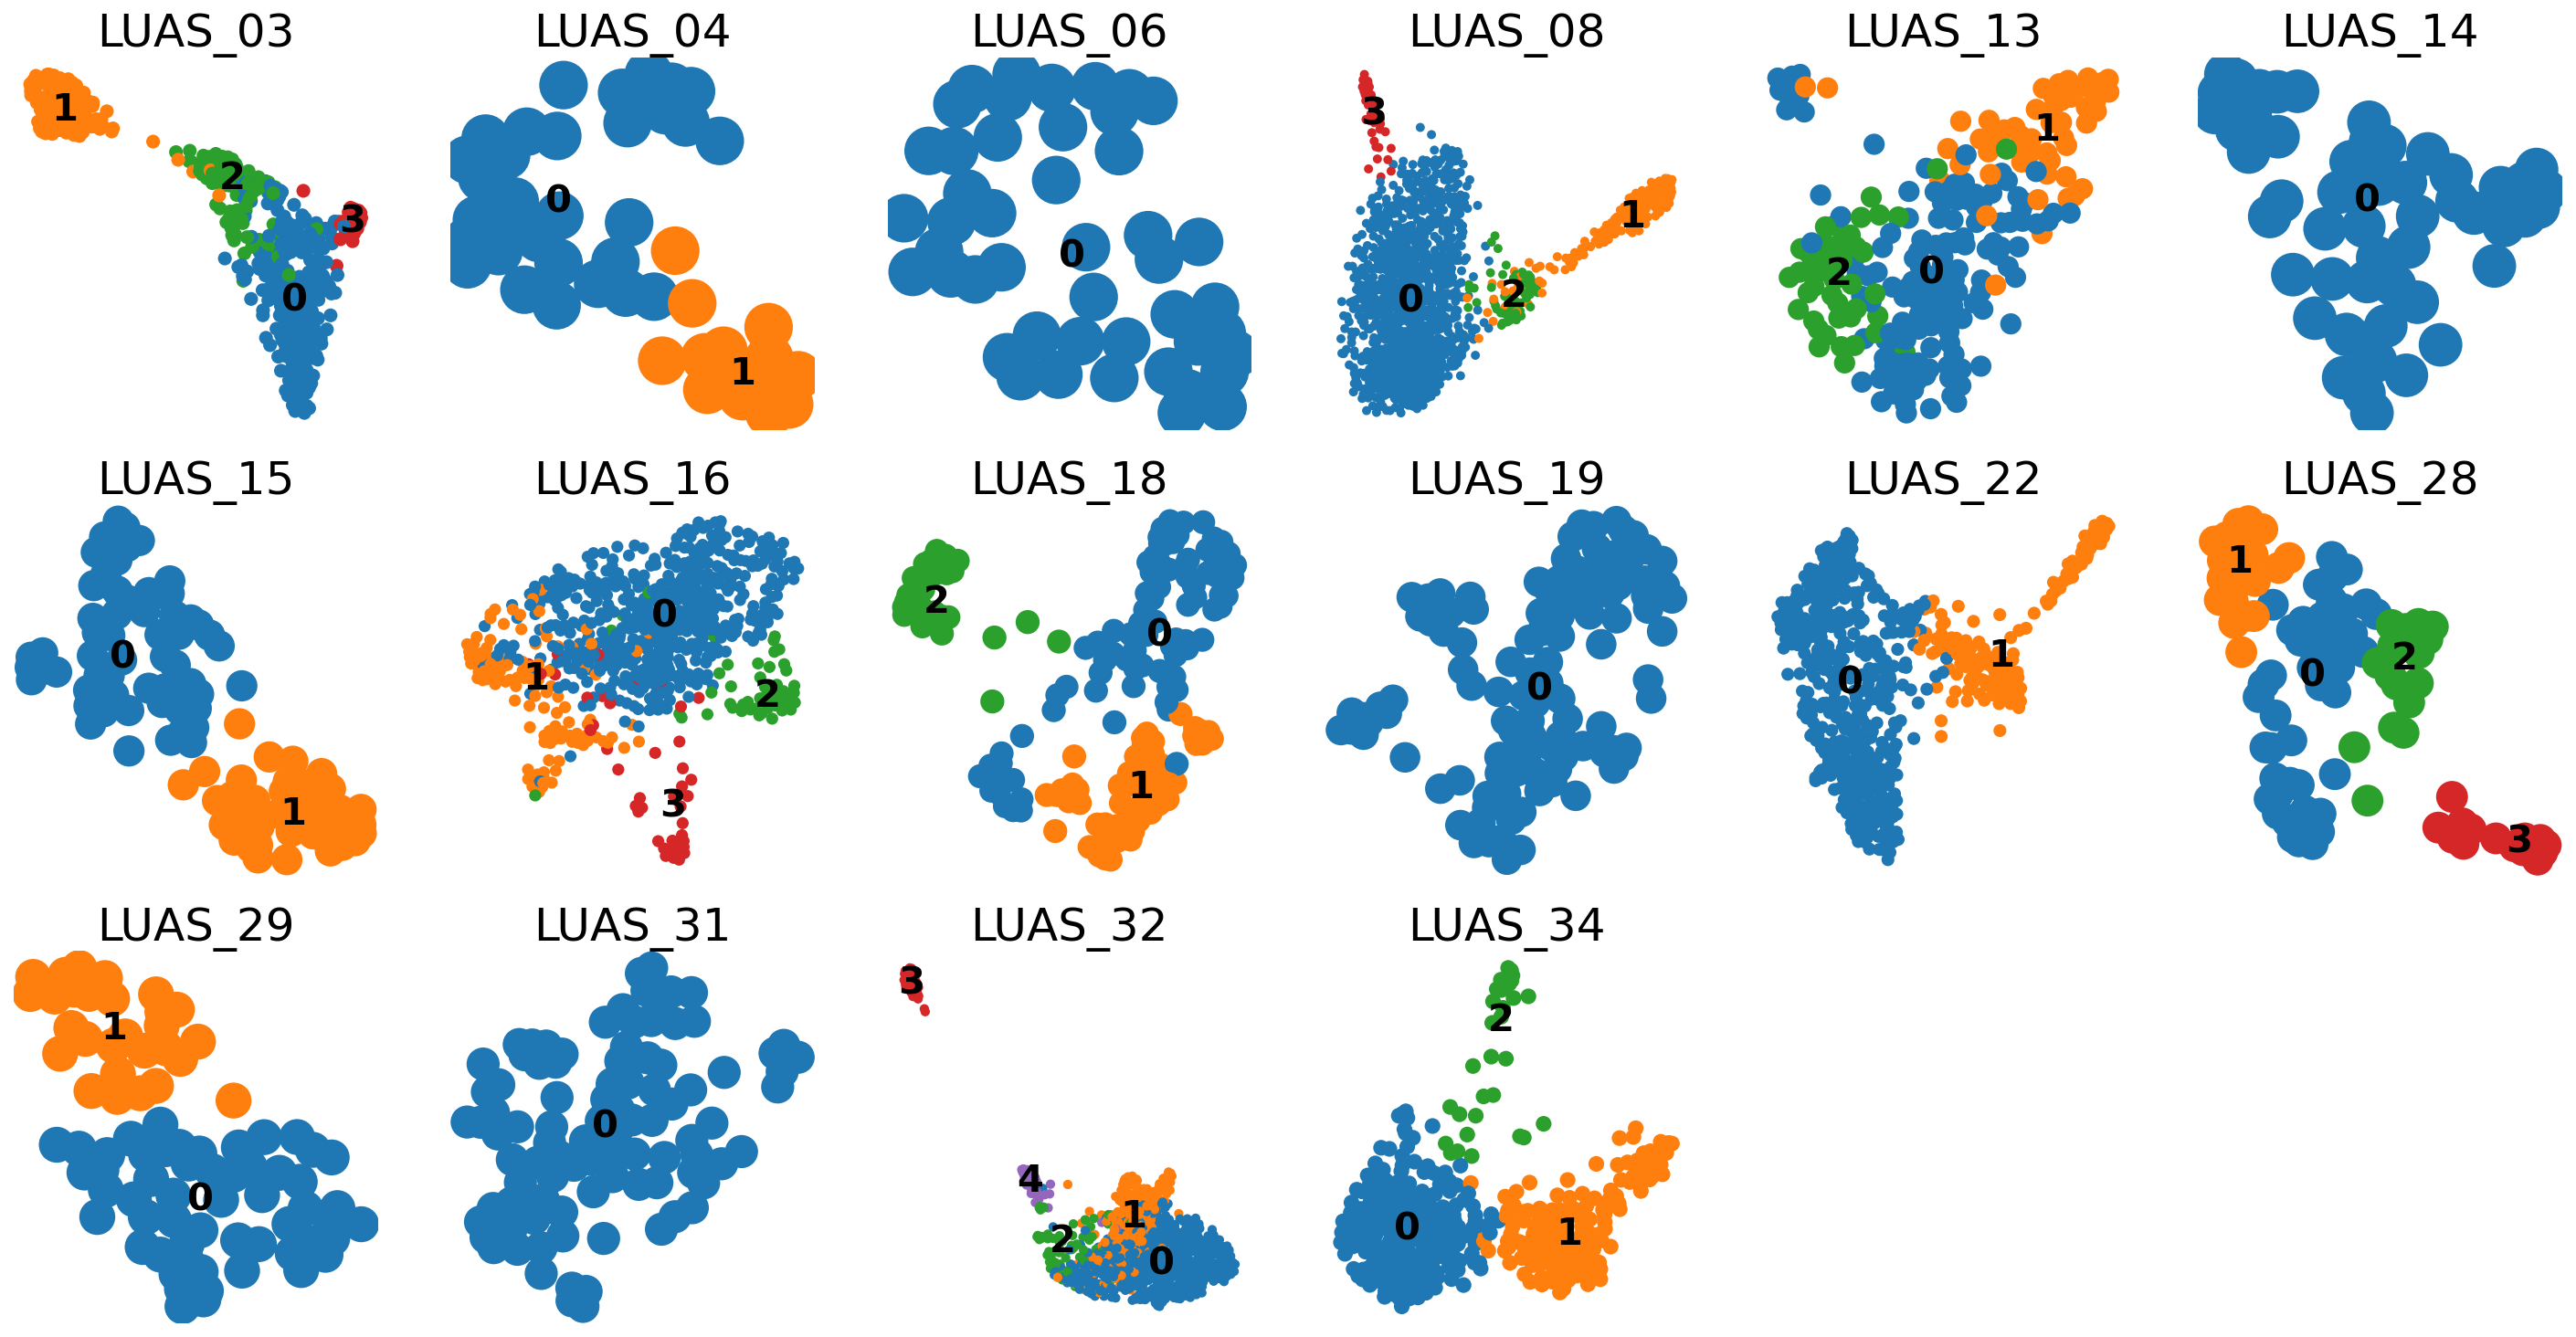

In [27]:
import math
cluster_labels = pd.read_csv(
    f'{luas_dir}/epigenetic/accessibility_landscape/v4/out/compare_vs_gorces/cell_pseudobulk_labels.csv',
    index_col=0,
).iloc[:, 0]
n_cols = 6  # choose how many columns you want
n_samples = len(samples)
n_rows = math.ceil(n_samples / n_cols)

fig, axes = plt.subplots(
    n_rows, n_cols, figsize=(4*n_cols, 4*n_rows), dpi=150, gridspec_kw={'wspace': 0.2, 'hspace': 0.2}
)
axes = axes.flat
for i, sample in enumerate(sorted(samples)):
    mdata = mudata.read(f'{luas_dir}/epigenetic/rna_atac_pseudotime/data/{sample}.h5mu')
    sample_cl = cluster_labels[cluster_labels.index.str.split('---').str[0] == sample]
    sample_cl.index = sample_cl.index.str.split('---').str[1]
    sample_cl = sample_cl.str.split('_').str[1]
    mdata.obs['leiden'] = sample_cl

    # plot into the correct axis
    sc.pl.draw_graph(
        mdata,               # or mdata['atac'], or mdata if integrated
        color='leiden',
        ax=axes[i],
        show=False,
        title=sample,
        frameon=False,
        legend_loc='on data',
        legend_fontsize=20,
    )
    axes[i].set_title(sample, fontsize=24)

for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

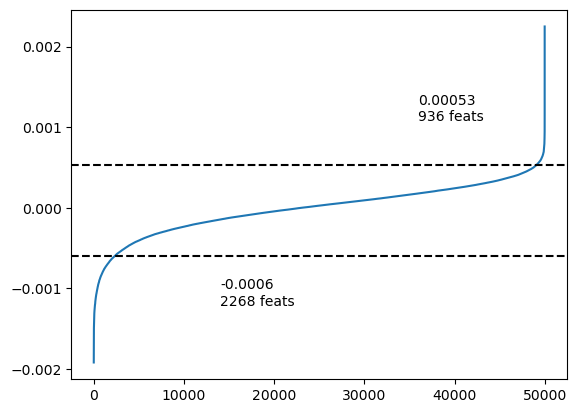

In [28]:
from kneed import KneeLocator
coef = atac_model.coef_[0]
xr = np.arange(len(coef))
scoef = sorted(coef)
kl = KneeLocator(xr, scoef, curve='convex', S=4)
pos_cutoff = scoef[kl.knee]
kl = KneeLocator(xr, scoef, curve='concave', S=4)
neg_cutoff = scoef[kl.knee]
plt.plot(xr, scoef)
plt.axhline(pos_cutoff, linestyle='--', color='k')
plt.axhline(neg_cutoff, linestyle='--', color='k')
n_pos = np.sum(scoef >= pos_cutoff)
n_neg = np.sum(scoef <= neg_cutoff)
plt.text(0.7, 0.7, f'{pos_cutoff:.2}\n{n_pos} feats', transform=plt.gca().transAxes)
plt.text(0.3, 0.2, f'{neg_cutoff:.2}\n{n_neg} feats', transform=plt.gca().transAxes)
plt.show()

In [75]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
new_logit_baseline = 2.9
factor = 1.33
atac_probs = sigmoid(factor*(atac_logits - new_logit_baseline))
concat_mdata.obs['ATAC_SCC_prob'] = atac_probs

In [76]:
import os
gene_set = 'max_fdr_1e-6_min_logfc_2_top_200_per'
C = 0.001

model_dir = f'/data1/chanj3/LUAS.multiome.results/TCGA_expression_modeling/out/log_reg/luad_vs_lusc_{gene_set}'
with open(f'{model_dir}/models.pkl', 'rb') as f:
    models = pickle.load(f)
rna_model = models[C]
genes = rna_model.feature_names_in_
X = pyreadr.read_r(f'{out_dir}/metacells_rna_log2cpm_TMM.rds')[None].T
X = subset_peaks(X, genes)
rna_pseudobulk_probs = rna_model.predict_proba(X)

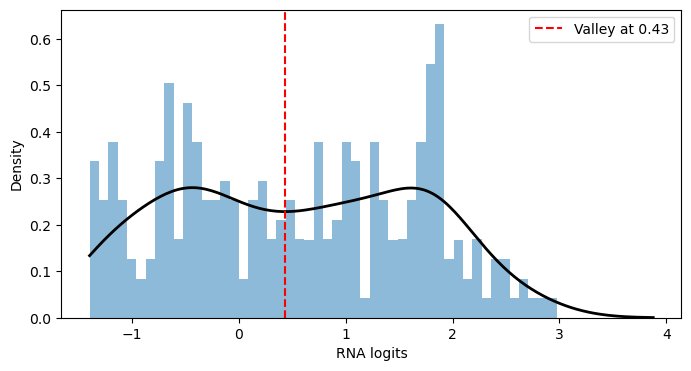

In [77]:
from scipy import stats
from scipy.signal import find_peaks

rna_logits = rna_model.decision_function(X)
# Create density estimate
density = stats.gaussian_kde(rna_logits)
x_range = np.linspace(rna_logits.min(), atac_logits.max(), 200)
density_vals = density(x_range)

# Find local minima in density
peaks, _ = find_peaks(-density_vals)  # negative to find valleys instead of peaks
if len(peaks) > 0:
    # Get the most prominent valley
    valley_x = x_range[peaks[np.argmax(density_vals[peaks])]]
else:
    # If no clear valley, use median
    valley_x = np.median(atac_logits)

# Plot
plt.figure(figsize=(8, 4))
plt.hist(rna_logits, bins=50, density=True, alpha=0.5)
plt.plot(x_range, density_vals, 'k-', lw=2)
plt.axvline(valley_x, color='r', linestyle='--', label=f'Valley at {valley_x:.2f}')
plt.xlabel('RNA logits')
plt.ylabel('Density')
plt.legend()
plt.show()

In [1]:
adjusted_atac_logits = 1.33*(atac_logits - 2.9)
# Create density estimate
density = stats.gaussian_kde(adjusted_atac_logits)
x_range = np.linspace(adjusted_atac_logits.min(), adjusted_atac_logits.max(), 200)
density_vals = density(x_range)
# Plot
plt.figure(figsize=(8, 4))
plt.hist(adjusted_atac_logits, bins=50, density=True, alpha=0.5, label='adjusted ATAC logits')
plt.plot(x_range, density_vals, 'k-', lw=2)

# Create density estimate
density = stats.gaussian_kde(rna_logits)
x_range = np.linspace(rna_logits.min(), rna_logits.max(), 200)
density_vals = density(x_range)
# Plot
plt.figure(figsize=(8, 4))
plt.hist(rna_logits, bins=50, density=True, alpha=0.5, label='RNA logits')
plt.plot(x_range, density_vals, 'k-', lw=2)

plt.xlabel('logits')
plt.ylabel('Density')
plt.legend()
plt.show()

NameError: name 'atac_logits' is not defined

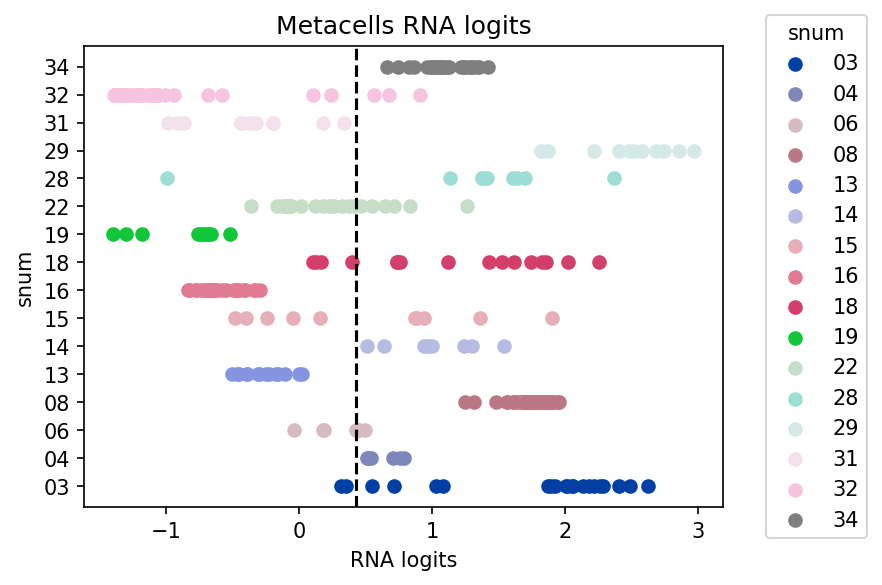

In [78]:
snums = X.index.str.split('---').str[1].str.split('_').str[1]
#snums = X.index.str.split('_').str[0]
# Assign y levels to snums
unique_snums = sorted(set(snums))
snum_to_y = {snum: i for i, snum in enumerate(unique_snums)}

# Build colors
colors = [sn2color[snum] for snum in snums]

# Scatter plot
plt.figure(figsize=(6, 4), dpi=150)
for snum in unique_snums:
    mask = snums == snum
    plt.scatter(
        rna_logits[mask],
        [snum_to_y[snum]] * mask.sum(),
        color=sn2color[snum],
        label=snum
    )
new_logit_baseline = 0.43
plt.axvline(new_logit_baseline, color='black', linestyle='--')
plt.yticks(range(len(unique_snums)), unique_snums)
plt.xlabel("RNA logits")
plt.ylabel("snum")
plt.legend(title="snum", bbox_to_anchor=(1.05, 0.5), loc="center left")
plt.tight_layout()
#plt.title('Pseudobulked clusters ATAC logits')
plt.title('Metacells RNA logits')
plt.show()

In [79]:
concat_mdata.obs['RNA_SCC_prob'] = rna_pseudobulk_probs[:, 1]

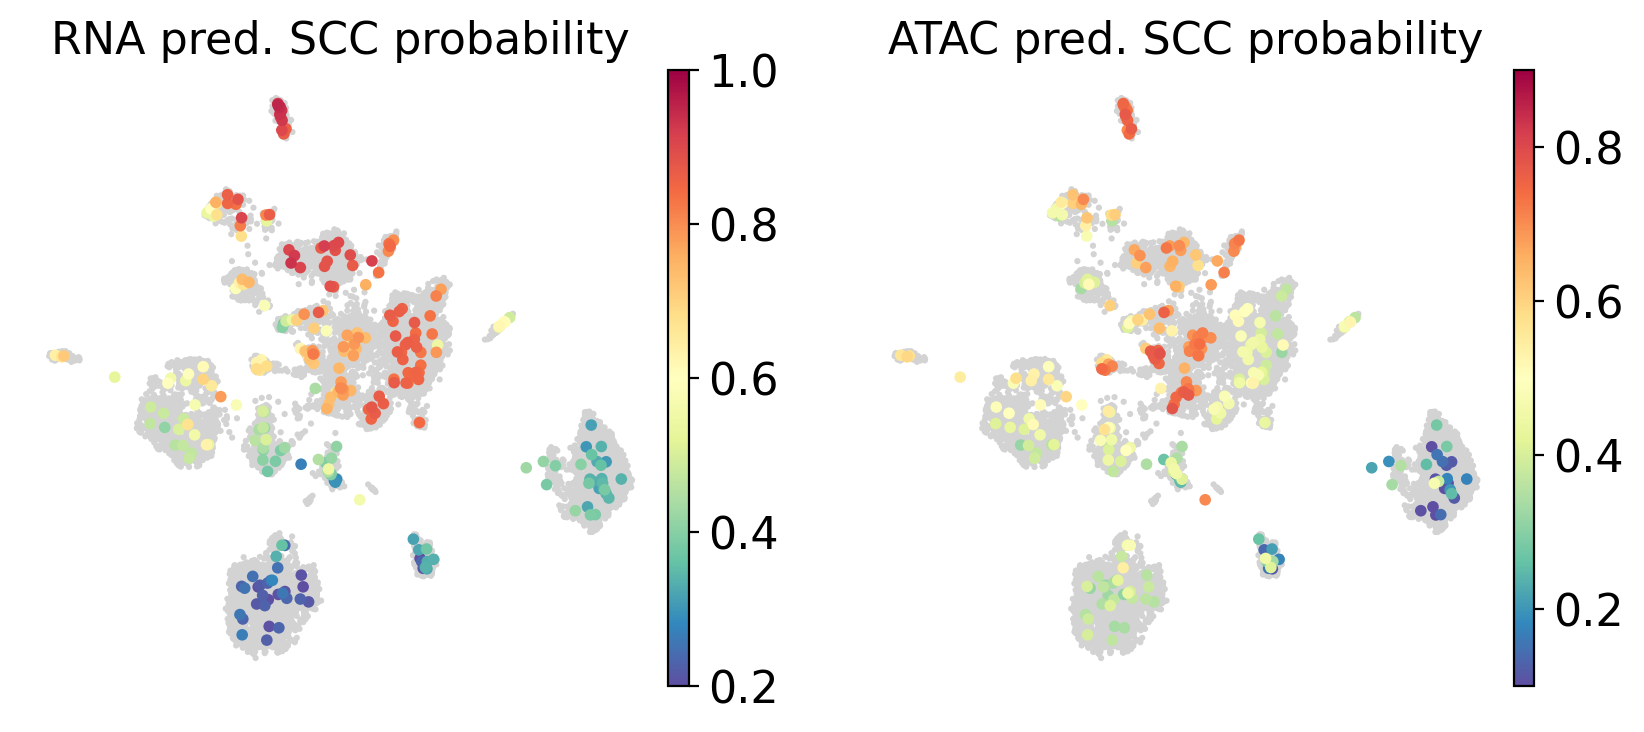

In [82]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'wspace': 0.2}, dpi=200)
keys = ['RNA_SCC_prob', 'ATAC_SCC_prob']
titles = ['RNA pred. SCC probability', 'ATAC pred. SCC probability']
vmins = [0.2, 0.1]
vmaxes = [1, 0.9]
for i, key in enumerate(keys):
    ax = axes[i]
    sc.pl.umap(adata, ax=ax, show=False, title='', frameon=False, s=20)
    sc.pl.umap(concat_mdata, color=[key], ax=ax, show=False, frameon=False, s=70, cmap='Spectral_r',
               vmax=vmaxes[i], vmin=vmins[i], title=titles[i],)
    ax.set_title(ax.get_title(), fontsize=16)
    cbar = ax.collections[-1].colorbar
    cbar.ax.tick_params(labelsize=16)
plt.show()

In [113]:
new_sn2color = {
    '03': "#F50B0B",   # red
    '04': '#009ADE',   # blue
    '06': '#00CD6C',   # green
    '08': '#AF58BA',   # purple
    '13': '#FFC61E',   # yellow
    '14': '#F28522',   # orange
    '15': '#A0B1BA',   # grey
    '16': '#7B4B94',   # dark purple
    '18': '#FF9287',   # salmon
    '19': "#747474",   # dark grey
    '22': '#0076BB',   # bright blue
    '28': '#FFBE0B',   # gold
    '29': '#2E5A87',   # navy
    '31': '#FB5607',   # bright orange
    '32': "#FF4B99",   # dark pink
    '34': '#8338EC'    # violet
}

... storing 'sample_num' as categorical


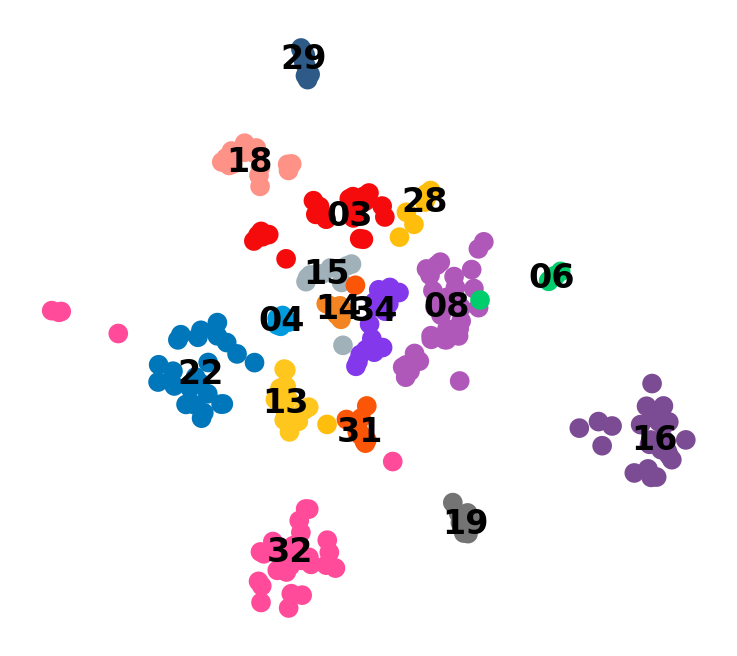

In [114]:
fig, ax = plt.subplots(1, 1, figsize=(4.5, 4), dpi=200)
#sc.pl.umap(adata, ax=ax, show=False, frameon=False)
concat_mdata.obs['sample_num'] = concat_mdata.obs['sample_name'].str.split('_').str[1]
sc.pl.umap(concat_mdata, color=['sample_num'], ax=ax, show=False, legend_loc='on data', title='', frameon=False, s=200,
           legend_fontsize=12, palette=new_sn2color)
plt.show()

In [34]:
concat_mdata

MuData object with n_obs × n_vars = 272 × 597224
  obs:	'sample_name', 'ATAC_SCC_prob', 'RNA_SCC_prob', 'sample_num'
  uns:	'sample_num_colors'
  obsm:	'joint_embedding', 'X_umap'
  2 modalities
    atac:	272 x 562709
      obs:	'n_cells', 'total_counts', 'sample_name'
    rna:	272 x 34515
      obs:	'n_cells', 'total_counts', 'sample_name'

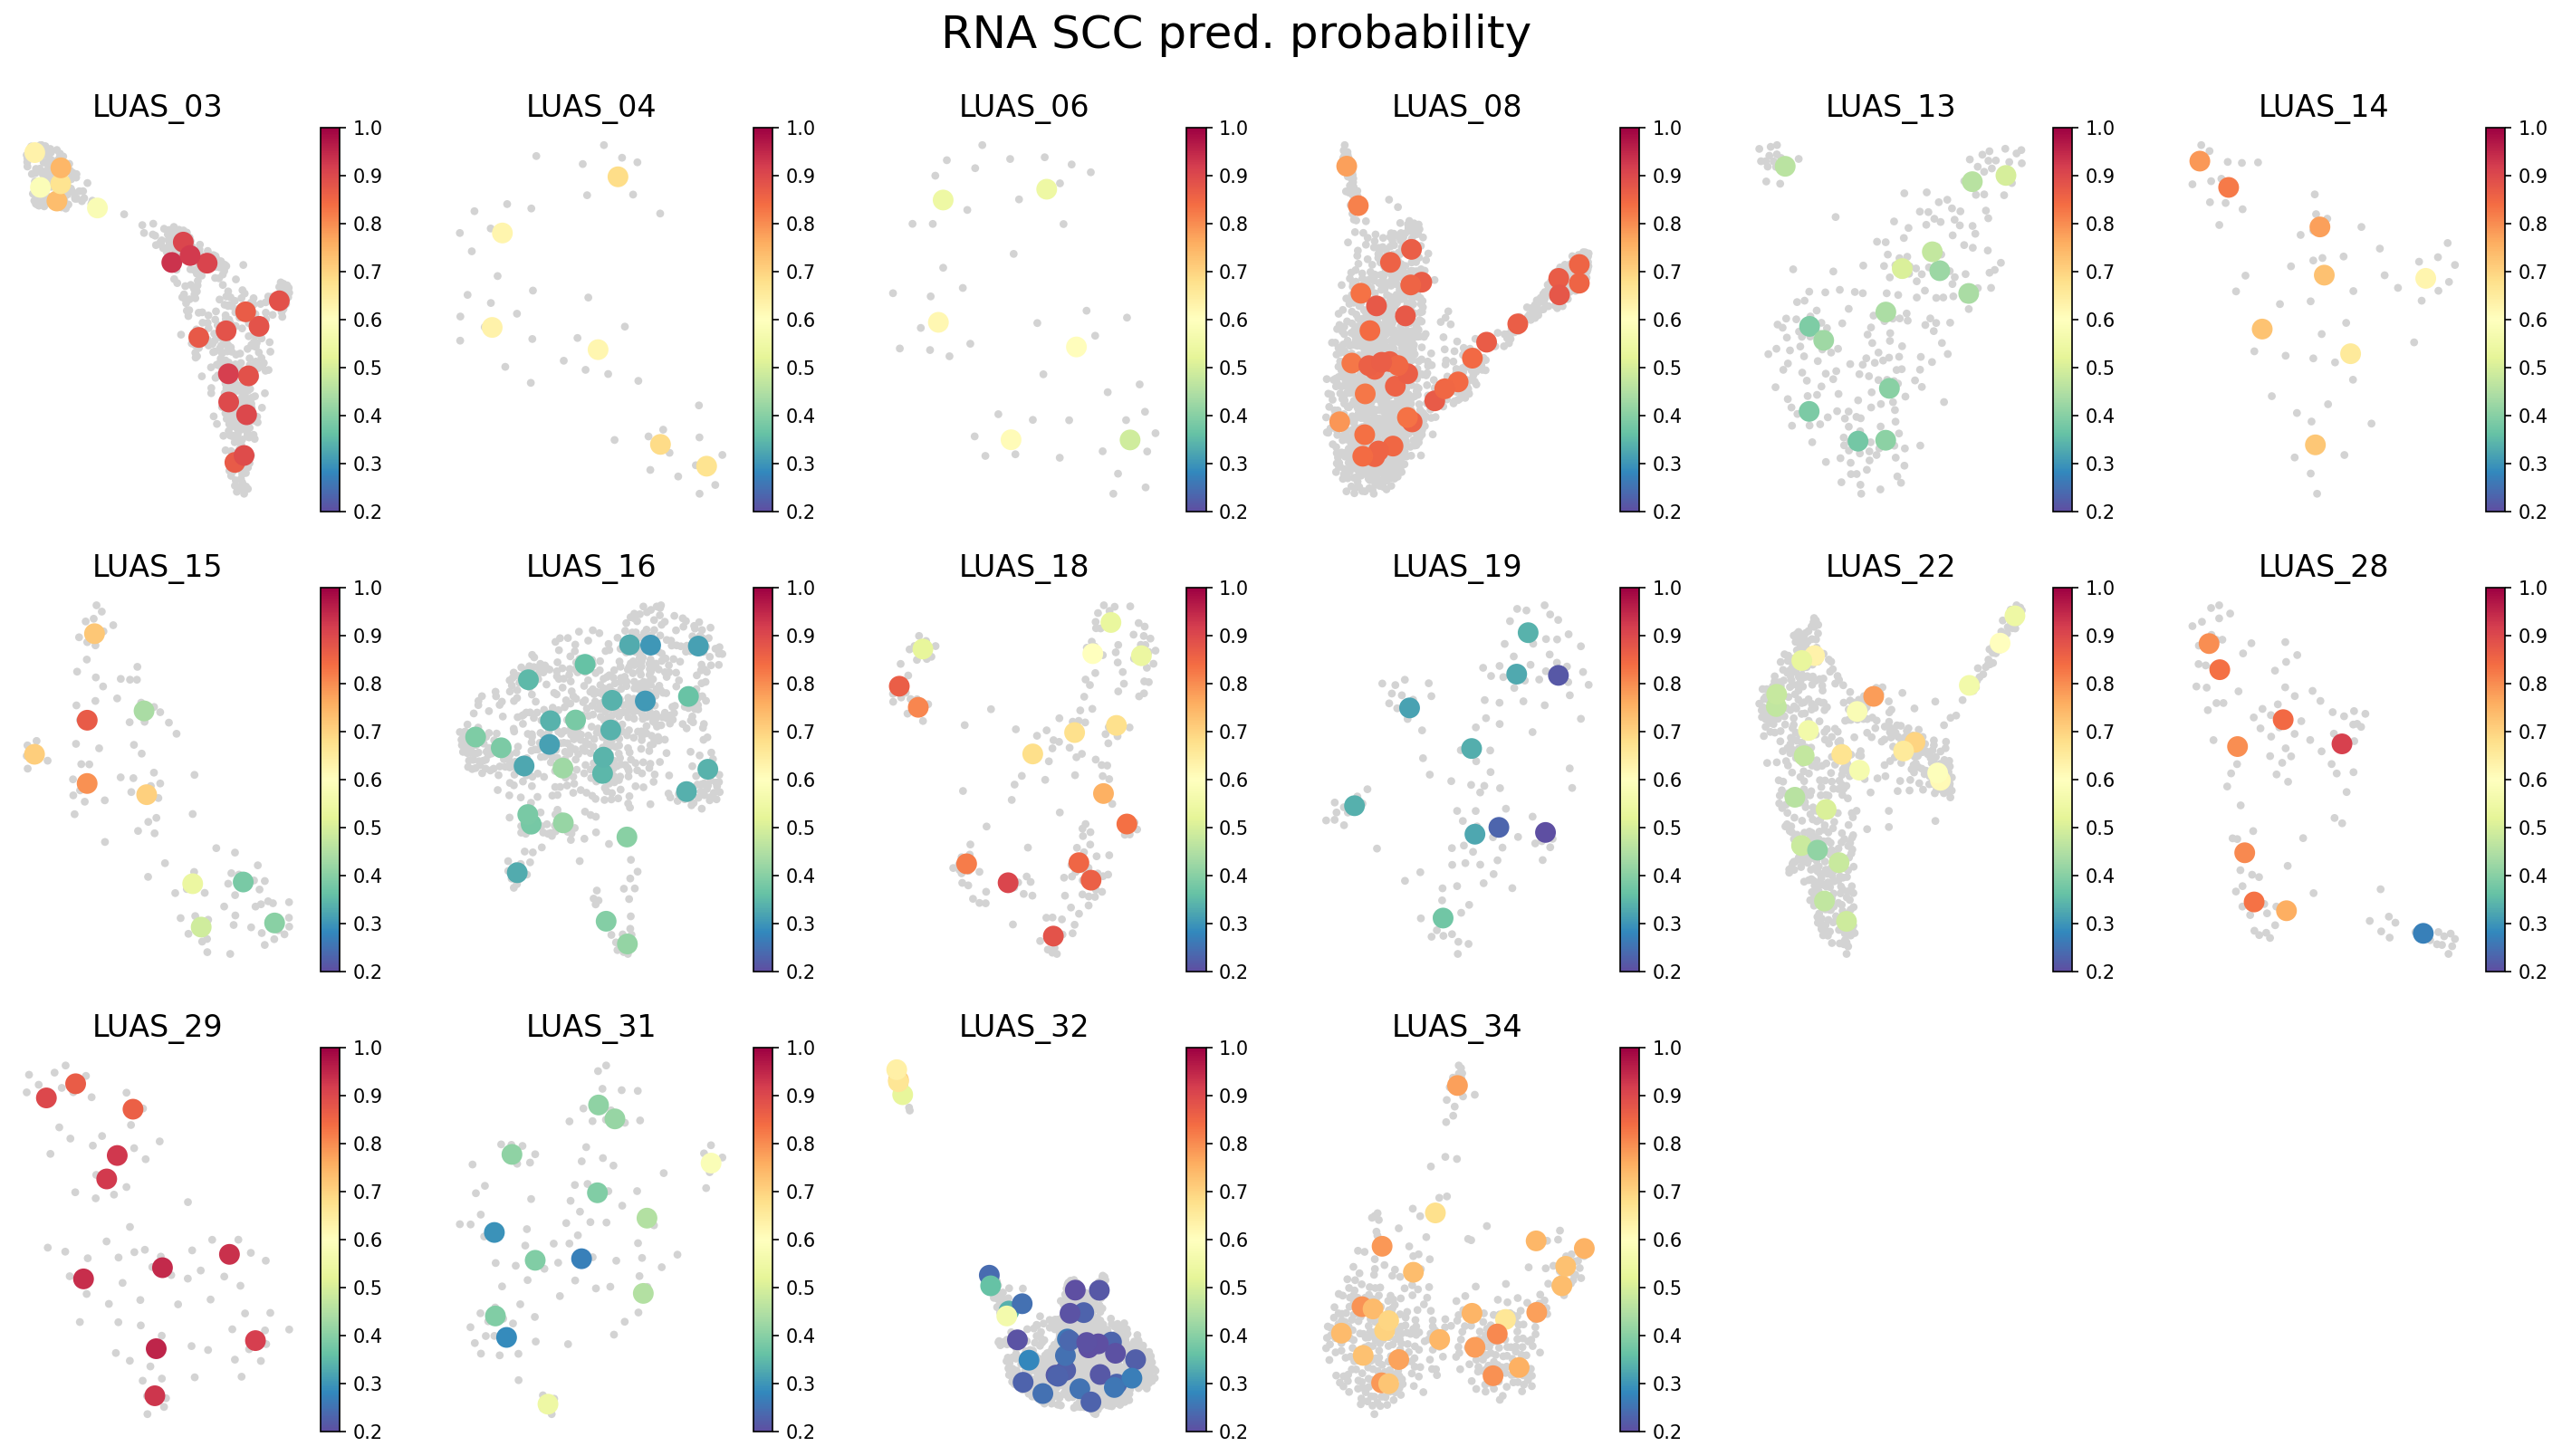

In [83]:
import math
import warnings
warnings.filterwarnings('ignore')
n_cols = 6  # choose how many columns you want
n_samples = len(samples)
n_rows = math.ceil(n_samples / n_cols)

fig, axes = plt.subplots(
    n_rows, n_cols, figsize=(4*n_cols, 4*n_rows), dpi=150, 
    gridspec_kw={'wspace': 0.2, 'hspace': 0.2}
)
axes = axes.flat

for i, sample in enumerate(sorted(samples)):
    # Load the single-cell data
    mdata = mudata.read(f'{seacells_dir}/{sample}.h5mu')
    
    # Get SEACell probabilities for this sample
    sample_seacells = concat_mdata[concat_mdata.obs.index.str.contains(sample)]
    seacell_probs = sample_seacells.obs['RNA_SCC_prob']
    
    # Create a mapping from SEACell to probability
    seacell_to_prob = {
        idx.split('---')[0]: prob 
        for idx, prob in zip(seacell_probs.index, seacell_probs)
    }
    
    # Plot single cells in gray first
    sc.pl.draw_graph(
        mdata,
        ax=axes[i],
        show=False,
        size=70,
        title=sample,
        frameon=False
    )
    
    # Get coordinates for SEACells (mean position of cells in each SEACell)
    seacell_coords = {}
    coords = mdata.obsm['X_draw_graph_fa']  # or whatever your layout key is
    for seacell in set(mdata.obs['SEACell']):
        mask = mdata.obs['SEACell'] == seacell
        seacell_coords[seacell] = coords[mask].mean(axis=0)
    
    # Plot SEACells colored by probability
    x_coords = [coord[0] for coord in seacell_coords.values()]
    y_coords = [coord[1] for coord in seacell_coords.values()]
    colors = [seacell_to_prob[seacell] for seacell in seacell_coords.keys()]
    
    scatter = axes[i].scatter(
        x_coords, y_coords,
        c=colors,
        cmap='Spectral_r',
        s=100,
        vmin=0.2,
        vmax=1,
    )
    plt.colorbar(scatter, ax=axes[i])
    axes[i].set_title(sample, fontsize=16)

# Turn off empty subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')
fig.suptitle('RNA SCC pred. probability', fontsize=24)
fig.subplots_adjust(top=0.91)
# Add colorbar
plt.tight_layout()
plt.show()

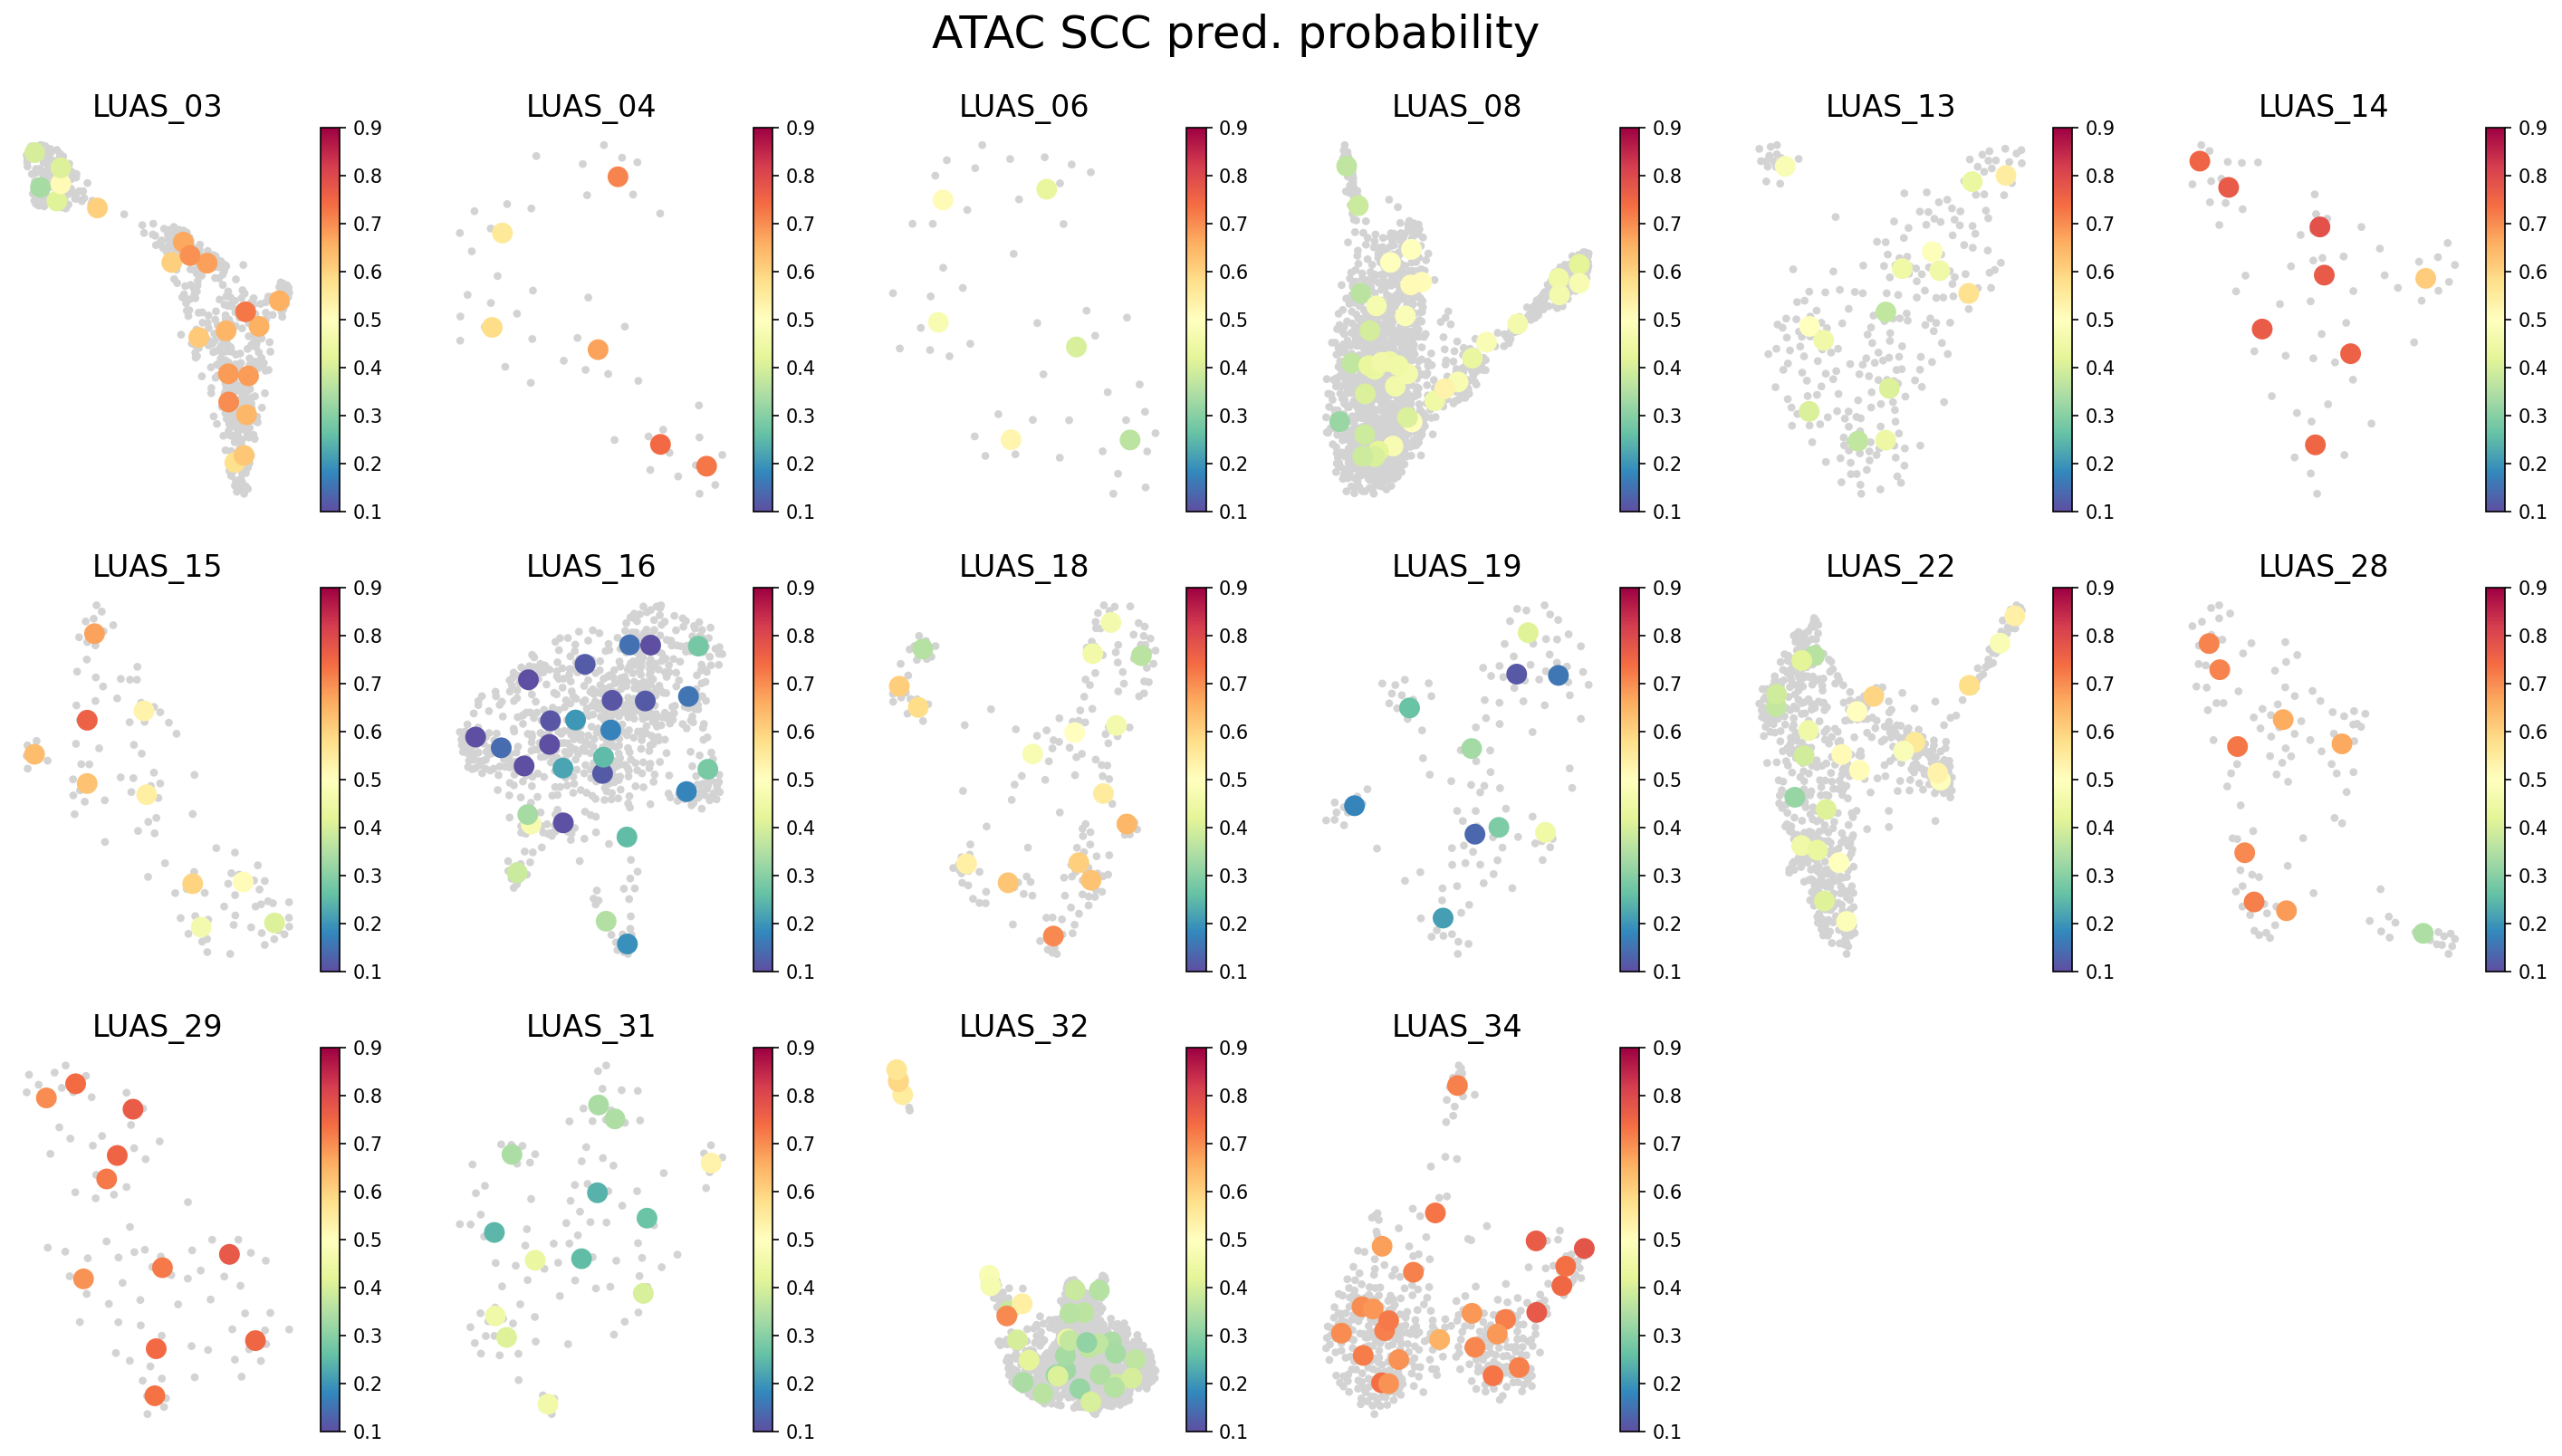

In [86]:
import math
import warnings
warnings.filterwarnings('ignore')
n_cols = 6  # choose how many columns you want
n_samples = len(samples)
n_rows = math.ceil(n_samples / n_cols)

fig, axes = plt.subplots(
    n_rows, n_cols, figsize=(4*n_cols, 4*n_rows), dpi=150, 
    gridspec_kw={'wspace': 0.2, 'hspace': 0.2}
)
axes = axes.flat

for i, sample in enumerate(sorted(samples)):
    # Load the single-cell data
    mdata = mudata.read(f'{seacells_dir}/{sample}.h5mu')
    
    # Get SEACell probabilities for this sample
    sample_seacells = concat_mdata[concat_mdata.obs.index.str.contains(sample)]
    seacell_probs = sample_seacells.obs['ATAC_SCC_prob']
    
    # Create a mapping from SEACell to probability
    seacell_to_prob = {
        idx.split('---')[0]: prob 
        for idx, prob in zip(seacell_probs.index, seacell_probs)
    }
    
    # Plot single cells in gray first
    sc.pl.draw_graph(
        mdata,
        ax=axes[i],
        show=False,
        size=70,
        title=sample,
        frameon=False
    )
    
    # Get coordinates for SEACells (mean position of cells in each SEACell)
    seacell_coords = {}
    coords = mdata.obsm['X_draw_graph_fa']  # or whatever your layout key is
    for seacell in set(mdata.obs['SEACell']):
        mask = mdata.obs['SEACell'] == seacell
        seacell_coords[seacell] = coords[mask].mean(axis=0)
    
    # Plot SEACells colored by probability
    x_coords = [coord[0] for coord in seacell_coords.values()]
    y_coords = [coord[1] for coord in seacell_coords.values()]
    colors = [seacell_to_prob[seacell] for seacell in seacell_coords.keys()]
    
    scatter = axes[i].scatter(
        x_coords, y_coords,
        c=colors,
        cmap='Spectral_r',
        s=100,
        vmin=0.1,
        vmax=0.9,
    )
    plt.colorbar(scatter, ax=axes[i])
    axes[i].set_title(sample, fontsize=16)

# Turn off empty subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')
fig.suptitle('ATAC SCC pred. probability', fontsize=24)
fig.subplots_adjust(top=0.91)
# Add colorbar
plt.tight_layout()
plt.show()

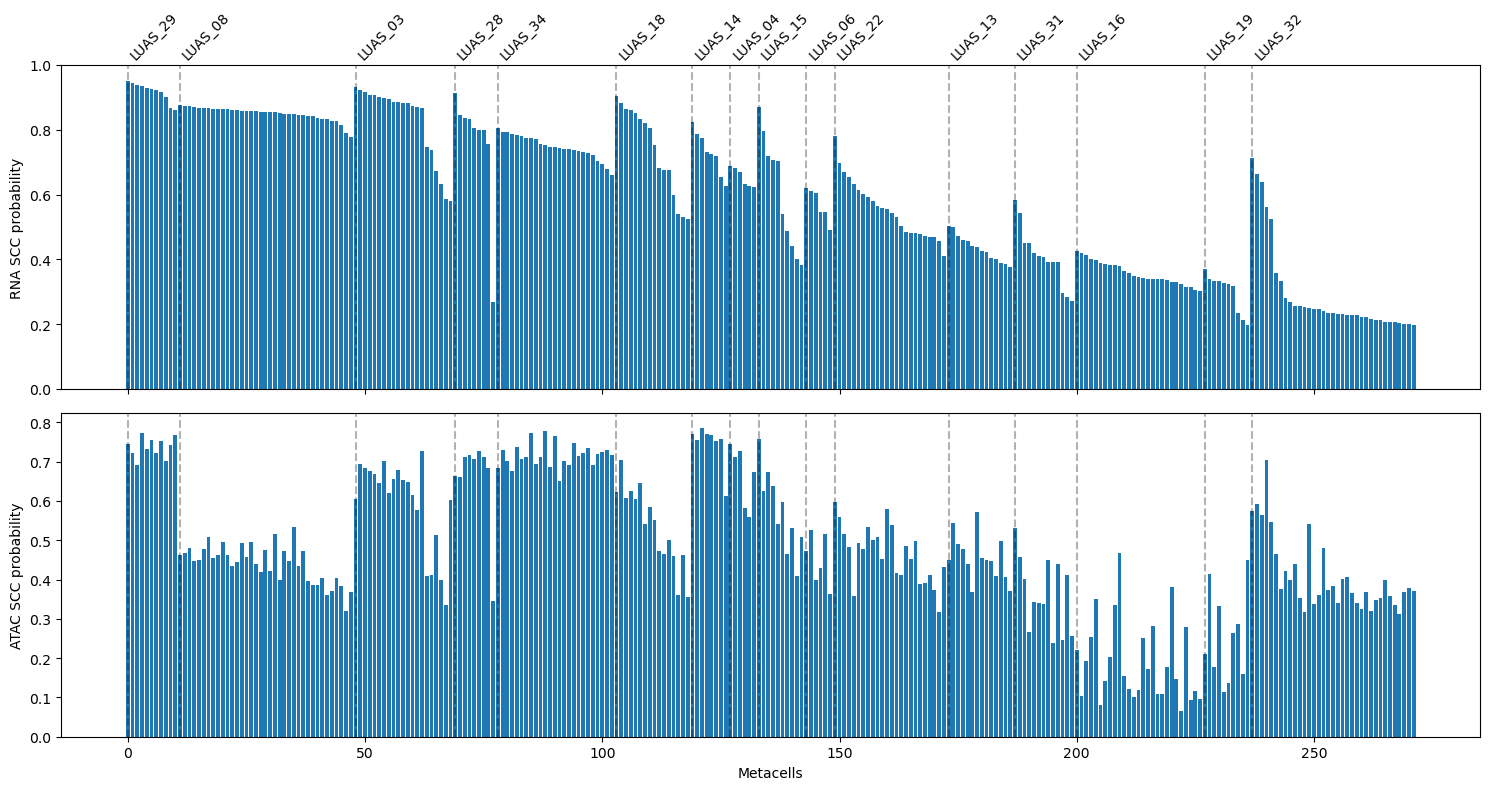

In [85]:
# Get sample and probability data into a DataFrame
metacell_data = pd.DataFrame({
    'sample': concat_mdata.obs.index.str.split('---').str[1],
    'metacell': concat_mdata.obs.index.str.split('---').str[0],
    'rna_prob': concat_mdata.obs['RNA_SCC_prob'],
    'atac_prob': concat_mdata.obs['ATAC_SCC_prob']
})

# Calculate mean RNA prob per sample for sorting
sample_means = metacell_data.groupby('sample')['rna_prob'].mean()
sample_order = sample_means.sort_values(ascending=False).index

# Sort within each sample by RNA prob
sorted_data = []
for sample in sample_order:
    sample_data = metacell_data[metacell_data['sample'] == sample].copy()
    sample_data = sample_data.sort_values('rna_prob', ascending=False)
    sorted_data.append(sample_data)

sorted_data = pd.concat(sorted_data)
sorted_data['index'] = range(len(sorted_data))

# Create the plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

# RNA probabilities
ax1.bar(sorted_data['index'], sorted_data['rna_prob'])
ax1.set_ylabel('RNA SCC probability')
ax1.set_ylim(0, 1)

# ATAC probabilities 
ax2.bar(sorted_data['index'], sorted_data['atac_prob'])
ax2.set_ylabel('ATAC SCC probability')
ax2.set_xlabel('Metacells')

# Add sample boundaries
prev_sample = None
for i, sample in enumerate(sorted_data['sample']):
    if sample != prev_sample:
        ax1.axvline(i, color='k', linestyle='--', alpha=0.3)
        ax2.axvline(i, color='k', linestyle='--', alpha=0.3)
        # Add sample label
        ax1.text(i, 1.02, sample, rotation=45, ha='left')
    prev_sample = sample

plt.tight_layout()
plt.show()

In [103]:
sn2color.keys()

dict_keys(['03', '04', '06', '08', '13', '14', '15', '16', '18', '19', '22', '28', '29', '31', '32', '34'])

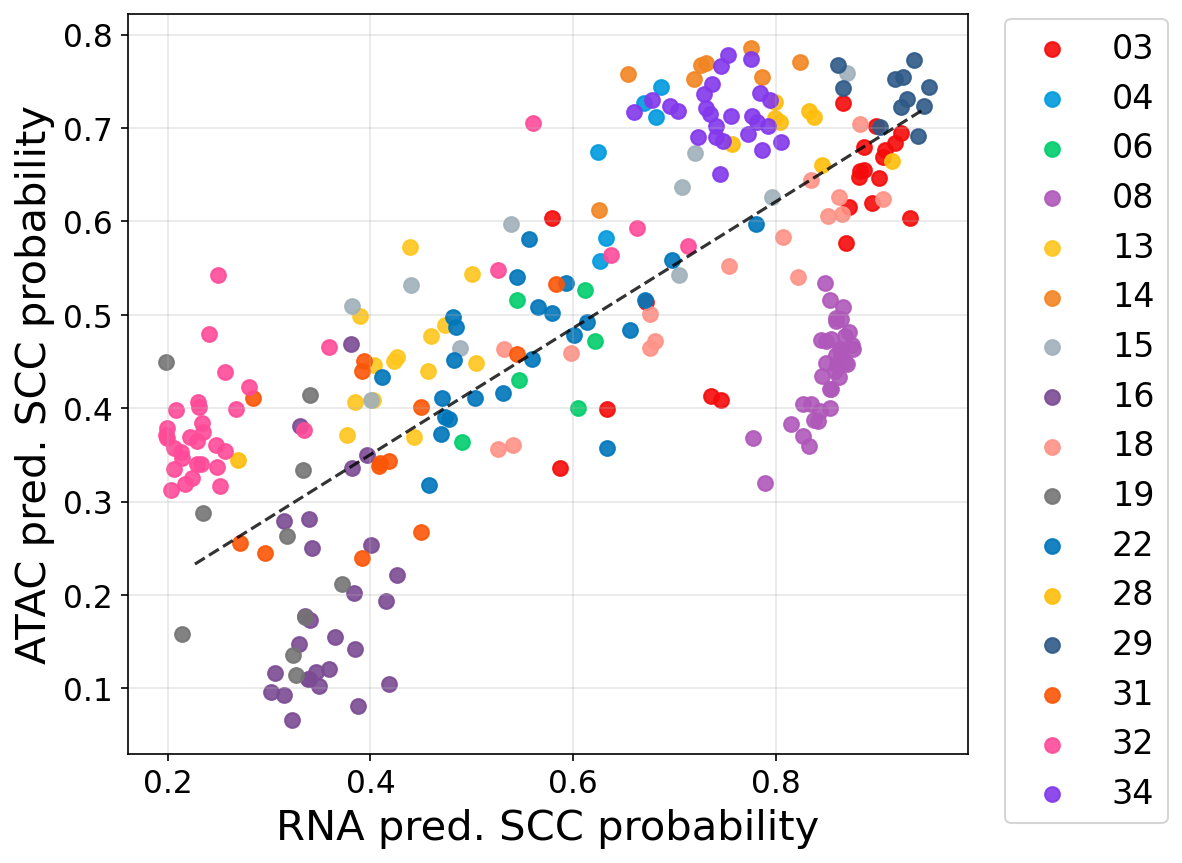

In [115]:
# Create scatter plot of RNA vs ATAC probabilities
plt.figure(figsize=(8, 6), dpi=150)

# Get sample numbers for coloring
sample_nums = metacell_data['sample'].str.split('_').str[1]
# Create scatter plot with points colored by sample
for snum in sorted(set(sample_nums)):
    mask = sample_nums == snum
    plt.scatter(
        metacell_data.loc[mask, 'rna_prob'],
        metacell_data.loc[mask, 'atac_prob'],
        c=new_sn2color[snum],
        label=snum,
        alpha=0.9,
        s=50,
    )

# Compute first principal component
X = np.column_stack([metacell_data['rna_prob'], metacell_data['atac_prob']])
X_centered = X - X.mean(axis=0)
_, eigenvectors = np.linalg.eigh(X_centered.T @ X_centered)
pc1 = eigenvectors[:, -1]  # Get the first principal component

# Project the range onto the PC line
x_range = np.linspace(metacell_data['rna_prob'].min(), metacell_data['rna_prob'].max(), 100)
center = X.mean(axis=0)
line_points = center + np.outer((x_range - center[0] + 0.04)*1.15, pc1)

# Plot the PC1 line
plt.plot(line_points[:, 0], line_points[:, 1], 'k--', alpha=0.8,)
         #label=f'PC1 (slope={pc1[1]/pc1[0]:.2f})')

plt.xlabel('RNA pred. SCC probability', fontsize=20)
plt.ylabel('ATAC pred. SCC probability', fontsize=20)
plt.legend(bbox_to_anchor=(1.025, 0.45), loc='center left', fontsize=16, title_fontsize=16)
plt.tick_params(labelsize=15)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [40]:
sample_to_sc_mdata[sample]

MuData object with n_obs × n_vars = 35 × 597224
  uns:	'cell_to_seacell'
  obsm:	'joint_embedding'
  2 modalities
    rna:	35 x 34515
      obs:	'n_cells', 'total_counts'
      var:	'n_metacells_expressed'
      uns:	'aggregation', 'n_source_cells'
    atac:	35 x 562709
      obs:	'n_cells', 'total_counts'
      var:	'n_metacells_accessible'
      uns:	'aggregation', 'n_source_cells'